In [1]:
import os

subj = "Subj1"
N_STAGES = 9
RERUN = True

exp = "exp_select_features_by_function"
features_type = 'exp_final_filtered'
function = 'best_multiple' # best_silh, best_multiple
os.makedirs(f"{subj}/{exp}/{features_type}/{function}", exist_ok = True)

In [2]:
%load_ext autoreload
%autoreload 2

import typing
import warnings
warnings.filterwarnings('ignore')

import SDA
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

import umap
import tqdm
import numpy
import pandas
import joblib
import sklearn.metrics
import sklearn.preprocessing
import sklearn.decomposition
import tqdm.contrib.itertools
import matplotlib.pyplot as plt
import sklearn.feature_selection
import sklearn.cross_decomposition

In [3]:
def explained_variance(features, reduced):
    pls = sklearn.cross_decomposition.PLSRegression(n_components = reduced.shape[1])
    y_pred = pls.fit(reduced, features).predict(reduced)
    return sklearn.metrics.r2_score(features, y_pred, multioutput = "variance_weighted")

### Selection

In [4]:
edges_true = numpy.loadtxt(f"{subj}/reproduction/internal/best_edges.txt").astype(numpy.int32)
df_features = pandas.read_feather(f'{subj}/{features_type}/all_features.feather')
print(df_features.shape)

features = sklearn.preprocessing.StandardScaler().fit_transform(df_features)
print(features.shape)

params = {
    'n_clusters_min': 2, 'n_clusters_max': 10,
    'k_neighbours': range(20, 51, 3),

    'st1_merging': SDA.StageMerging.BOTH,
    'st1_len_thresholds': 40,

    'n_cl_max_thr': [ 20 ],
    'k_neighb_max_thr': [ 50 ],
    'n_edge_clusters_min': 2, 'n_edge_clusters_max': 10,

    'st2_merging': SDA.StageMerging.NONE
}

(1046, 3799)
(1046, 3799)


In [5]:
def generate_merges(features: numpy.ndarray, st_edges: numpy.ndarray) -> typing.Set[typing.Tuple[int]]:
    if len(st_edges) < 3: return set()
    edges1 = SDA.stageprocess.merge_stages_1st_step_iter(features, st_edges)
    edges2 = SDA.stageprocess.merge_stages_2nd_step_iter(features, st_edges)
    merges1 = generate_merges(features, edges1)
    merges2 = generate_merges(features, edges2)
    return set([ tuple(st_edges) ]) | merges1 | merges2

def calc_score(features: numpy.ndarray, st_edges: numpy.ndarray) -> float:
    metrics = SDA.clustquality.calc_stage_metr_noground(features, st_edges, [ 'Silh' ]).mean()
    match function:
        case 'best_silh':
            return metrics['Silh']
        case 'best_multiple':
            return len(st_edges) * metrics['Silh']
    raise NotImplementedError(function)

def score_feature(i: int, n_jobs: int = 1, verbose: bool = False):
    sda = SDA.SDA(**params, scale = False, st1_calc_quality = False, st2_calc_quality = False, n_jobs = n_jobs, verbose = verbose)

    feature = features[:, i].reshape(-1, 1)
    results, _ = sda.apply(feature)

    edges_lists = set()
    for edges in map(numpy.array, set(map(tuple, results["St_edges"]))):
        edges_lists |= generate_merges(feature, edges)

    score = numpy.max([
        calc_score(feature, numpy.array(merge))
        for merge in edges_lists
    ])
    
    return {
        'index': i,
        'name': df_features.columns[i],
        'score': score,
        'mean': feature.mean(),
        'variance': feature.var(),
        'unique_values': len(numpy.unique(feature))
    }

In [6]:
if RERUN:
    scores = joblib.Parallel(n_jobs = 14)(joblib.delayed(score_feature)(i) for i in tqdm.trange(features.shape[1]))
    scores = pandas.DataFrame(list(scores))
else:
    scores = pandas.read_csv(f"{subj}/{exp}/{features_type}/{function}/scores_{features_type[4:]}.csv")
display(scores)

100%|██████████| 3799/3799 [3:17:54<00:00,  3.13s/it]  


,index,name,score,mean,variance,unique_values
0,0,channel-0 entropy dim-1,2.145634,-1.630308e-16,1.0,1046
1,1,channel-0 entropy dim-2,1.024900,3.396476e-16,1.0,1024
2,2,channel-0 numberofpoints dim-1,1.654075,1.630308e-16,1.0,72
3,3,channel-0 numberofpoints dim-2,1.363077,4.755066e-17,1.0,35
4,4,channel-0 amplitude-bottleneck dim-1,2.045160,5.434361e-17,1.0,1046
...,...,...,...,...,...,...
3794,3794,overall bd2 dim-3 mean,1.273571,-2.717181e-17,1.0,861
3795,3795,overall bd2 dim-3 std,1.564733,-4.755066e-17,1.0,700
3796,3796,overall bd2 dim-3 sum,2.375467,2.717181e-17,1.0,861
3797,3797,overall bd2 dim-3 norm-1,2.375467,2.717181e-17,1.0,861


In [7]:
scores.to_csv(f"{subj}/{exp}/{features_type}/{function}/scores_{features_type[4:]}.csv", index = False)
display(scores.sort_values(by = 'score', ascending = False))

,index,name,score,mean,variance,unique_values
2344,2344,channel-25 amplitude-silhouette-1-2 dim-1,6.226223,3.396476e-18,1.0,1046
2324,2324,channel-25 amplitude-landscape-1-1 dim-1,6.174875,0.000000e+00,1.0,1046
2354,2354,channel-25 amplitude-silhouette-2-2 norm-1,6.170178,4.755066e-17,1.0,1046
2158,2158,channel-23 amplitude-silhouette-1-1 norm-1,5.137822,0.000000e+00,1.0,1045
2343,2343,channel-25 amplitude-silhouette-1-1 norm-2,5.134884,1.698238e-17,1.0,1046
...,...,...,...,...,...,...
3129,3129,channel-34 entropy dim-2,0.173719,3.668194e-16,1.0,973
3242,3242,channel-35 amplitude-betti-2 norm-1,0.170526,-3.532335e-16,1.0,1030
3057,3057,channel-33 amplitude-betti-2 dim-2,0.140418,-7.302423e-17,1.0,49
181,181,channel-1 bd2 dim-2 sum,0.109238,-2.037885e-17,1.0,1043


### Tests

In [18]:
def test_thresholds(dim_reducer):
    [ 0.5, ..., 4 ]
    thresholds = list(map(lambda i: i / 100, range(50, 450, 25)))
    num_features = [ ]
    explained_variances_reduced = [ ]
    explained_variances_all = [ ]
    fmi_s = [ ]
    silh_15 = [ ]
    silh_reduced = [ ]
    silh_all = [ ]

    for threshold in tqdm.tqdm(thresholds):
        feature_idx = scores[scores["score"] > threshold]["index"].to_numpy()
        best_features = features[:, feature_idx]
        num_features.append(best_features.shape[1])
        
        reduced_features = dim_reducer.fit_transform(best_features)
        explained_variances_reduced.append(explained_variance(best_features, reduced_features))
        explained_variances_all.append(explained_variance(features, reduced_features))

        reduced_result, _ = SDA.SDA(n_jobs = 14, scale = False, verbose = False, st1_calc_quality = False).apply(reduced_features)

        try:
            reduced_best_result = SDA.analytics.best_result(reduced_result, key = 'Avg-Silh', n_stages = N_STAGES)
            reduced_edges = reduced_best_result['St_edges']

            fmi_s.append(SDA.clustquality.cluster_metrics_ground(edges_true, reduced_edges, [ "FMI" ])["FMI"])
            silh_15.append(SDA.clustquality.calc_stage_metr_noground(reduced_features, reduced_edges, [ "Silh" ]).mean()["Silh"])
            silh_reduced.append(SDA.clustquality.calc_stage_metr_noground(best_features, reduced_edges, [ "Silh" ]).mean()["Silh"])
            silh_all.append(SDA.clustquality.calc_stage_metr_noground(features, reduced_edges, [ "Silh" ]).mean()["Silh"])
        except:
            fmi_s.append(0)
            silh_15.append(0)
            silh_reduced.append(0)
            silh_all.append(0)
    

    results = numpy.vstack([
        thresholds, num_features,
        explained_variances_reduced, explained_variances_all,
        fmi_s, silh_15, silh_reduced, silh_all
    ]).T

    columns = [ 
        "thresholds", "num_features",
        "explained_variances_reduced", "explained_variances_all",
        "fmi_s", "silh_15", "silh_reduced", "silh_all"
    ]

    df = pandas.DataFrame(results, columns = columns)
    display(df)

    fig, axes = plt.subplots(2, 2, figsize = (20, 7))

    axes[0][0].plot(thresholds, num_features)
    axes[0][0].set_xlabel("Silh Threshold")
    axes[0][0].set_ylabel("Num features")

    axes[0][1].plot(thresholds, explained_variances_reduced, label = 'reduced')
    axes[0][1].plot(thresholds, explained_variances_all, label = 'all')
    axes[0][1].set_xlabel("Silh Threshold")
    axes[0][1].set_ylabel("Explained variance")
    axes[0][1].legend()

    axes[1][0].plot(thresholds, silh_15, label = 'Silh - 15')
    axes[1][0].plot(thresholds, silh_reduced, label = 'Silh - reduced')
    axes[1][0].plot(thresholds, silh_all, label = 'Silh - all')
    axes[1][0].set_xlabel("Silh Threshold")
    axes[1][0].set_ylabel("Silh")
    axes[1][0].legend()

    axes[1][1].plot(thresholds, fmi_s)
    axes[1][1].set_xlabel("Silh Threshold")
    axes[1][1].set_ylabel("FMI")

    fig.show()

    return df, fig

#### PCA

100%|██████████| 16/16 [09:00<00:00, 33.75s/it]


,thresholds,num_features,explained_variances_reduced,explained_variances_all,fmi_s,silh_15,silh_reduced,silh_all
0,0.50,3621.0,0.563763,0.550231,0.733233,0.174066,0.101044,0.096739
1,0.75,3299.0,0.583703,0.547680,0.694126,0.184458,0.112380,0.100867
2,1.00,2826.0,0.604287,0.542739,0.721498,0.202353,0.129550,0.108715
3,1.25,2213.0,0.628240,0.532249,0.684292,0.175610,0.115173,0.089464
4,1.50,1577.0,0.661257,0.513774,0.843465,0.198292,0.128588,0.091951
5,1.75,1056.0,0.694784,0.489646,0.686705,0.215853,0.150820,0.105104
6,2.00,645.0,0.739848,0.448682,0.628265,0.213757,0.156152,0.090275
7,2.25,420.0,0.787119,0.418683,0.704798,0.198335,0.153728,0.104267
8,2.50,246.0,0.815512,0.395200,0.627185,0.205014,0.164954,0.087437
9,2.75,145.0,0.877235,0.359395,0.654540,0.206692,0.184892,0.086066


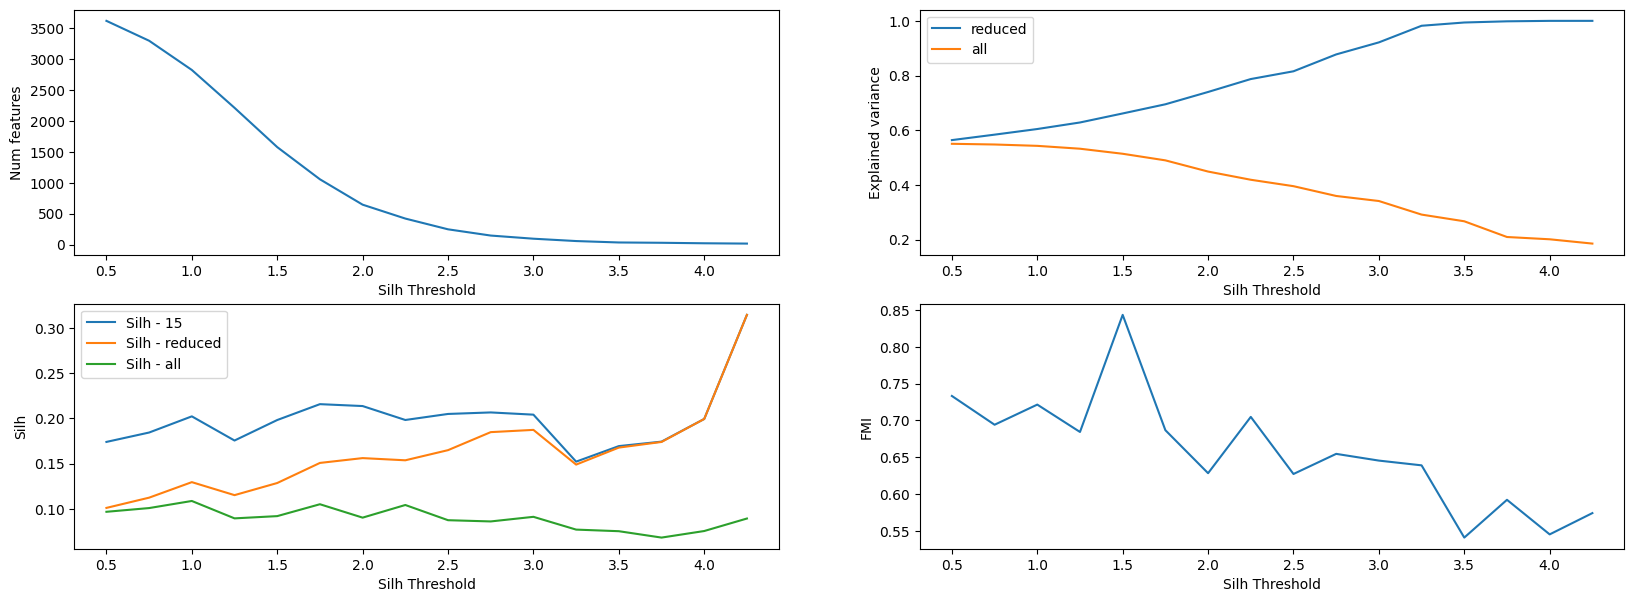

In [19]:
df_pca, fig_pca = test_thresholds(sklearn.decomposition.PCA(n_components = 15, svd_solver = "full", random_state = 42))

In [20]:
df_pca.to_csv(f"{subj}/{exp}/{features_type}/{function}/df_pca.csv", index = False)
fig_pca.savefig(f"{subj}/{exp}/{features_type}/{function}/fig_pca.svg")
fig_pca.savefig(f"{subj}/{exp}/{features_type}/{function}/fig_pca.png")

#### UMAP

100%|██████████| 16/16 [09:36<00:00, 36.06s/it]


,thresholds,num_features,explained_variances_reduced,explained_variances_all,fmi_s,silh_15,silh_reduced,silh_all
0,0.50,3621.0,0.399932,0.388814,0.000000,0.000000,0.000000,0.000000
1,0.75,3299.0,0.417457,0.390257,0.758515,0.340872,0.116436,0.104819
2,1.00,2826.0,0.430767,0.384190,0.735773,0.352225,0.117654,0.098227
3,1.25,2213.0,0.442183,0.375731,0.743881,0.366766,0.137876,0.109745
4,1.50,1577.0,0.454560,0.359151,0.741232,0.382371,0.137503,0.101085
5,1.75,1056.0,0.474960,0.351259,0.749784,0.414833,0.153973,0.106531
6,2.00,645.0,0.488407,0.320515,0.000000,0.000000,0.000000,0.000000
7,2.25,420.0,0.491455,0.309301,0.000000,0.000000,0.000000,0.000000
8,2.50,246.0,0.437817,0.293664,0.750928,0.380477,0.142893,0.098891
9,2.75,145.0,0.434183,0.269579,0.762682,0.330494,0.128554,0.098503


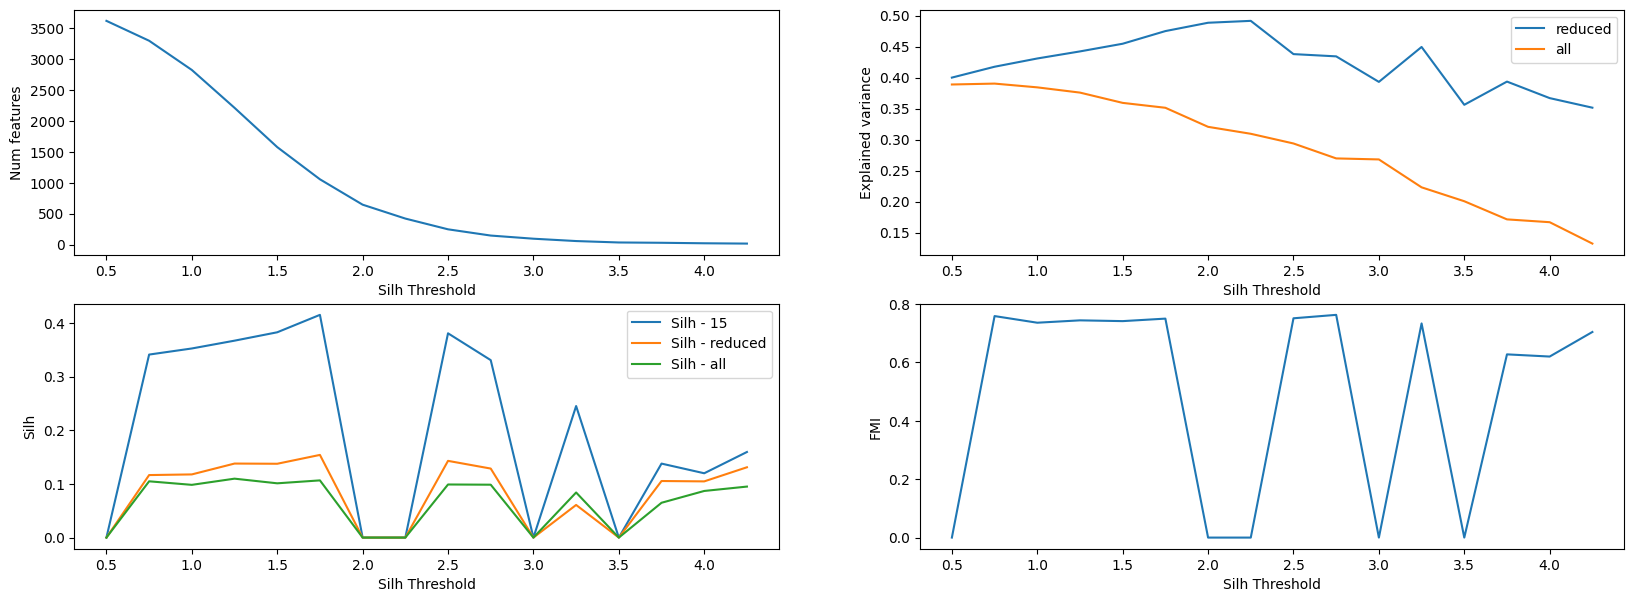

In [21]:
df_umap, fig_umap = test_thresholds(umap.UMAP(n_components = 15, random_state = 42))

In [22]:
df_umap.to_csv(f"{subj}/{exp}/{features_type}/{function}/df_umap.csv", index = False)
fig_umap.savefig(f"{subj}/{exp}/{features_type}/{function}/fig_umap.svg")
fig_umap.savefig(f"{subj}/{exp}/{features_type}/{function}/fig_umap.png")